# I) PROJECT INTRODUCTION

In this competition, we will build a model to transform an actual photo taken into Monet painting style.
We will use CycleGAN to build Generative Transformation Model with core architecture of Convolutional network, in which applying technique of encoding (downsample) and decoding (downsample) during Generator and Discriminator process.
To train this model during Generator and Discriminator, we will use provided set of 300 Monet-style image.
As the output to be submitted, the model will generate Monet-style images from 7000 actual photo as input testing.

*Disclaimer: copied notebook from recommended Tutorial only to adopt correct environment and suitable library version in Kaggle for model training. The code inside is self-exploration from various sources, see more at Reference session*

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Number of replicas: 1
2.6.4


# II) Exploratory Data Analysis (EDA) 

in this exploratory session, we will following these steps:
1) load in data and display sample to have some sense of the task for input and expected output
3) inspect sample's charater as preparation for model setup in next part

## 1. Load data

In [2]:
from tensorflow.keras import layers 

import tensorflow as tf
from tensorflow import keras

import keras_tuner as kt

import matplotlib.pyplot as plt

import numpy as np
import os
import time
import gc
import io
import shutil

import zipfile
import PIL
from IPython.display import display, clear_output

In [3]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [4]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


All the images for the competition are already sized to 256x256. As these images are RGB images, set the channel to 3. Additionally, we need to scale the images to a [-1, 1] scale. Because we are building a generative model, we don't need the labels or the image id so we'll only return the image from the TFRecord.

In [5]:
IMAGE_SIZE = [256, 256] 

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

Define the function to extract the image from the files.

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

Let's load in our datasets.

In [7]:
# let's have a look on 10 photos on each set of image
sample_size = 10 

monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(sample_size) #loading certain sample from whole dataset of monet
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(sample_size) #loading certain sample from whole dataset of photo

#samnple iteration
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

now let's have a look on dataset to see what we have on hand for Monet style to train and Photo will be used as input later

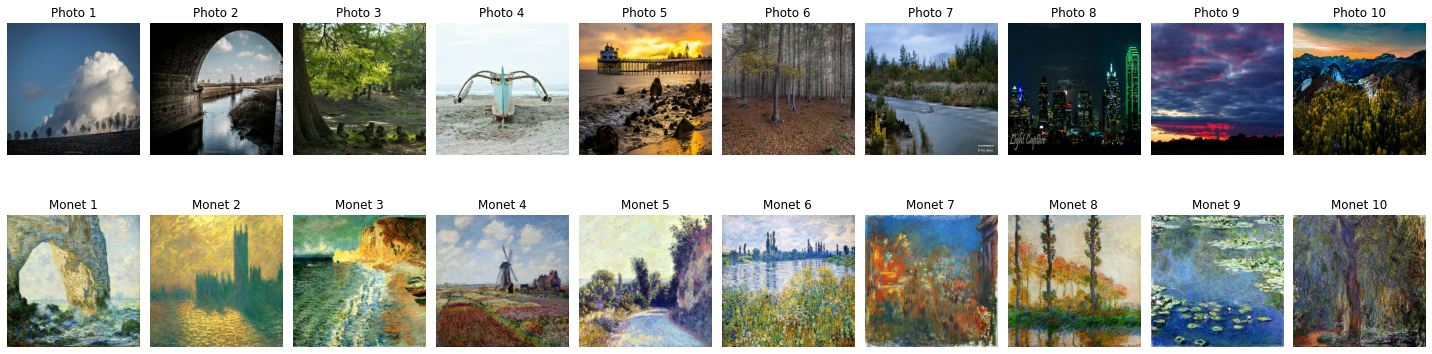

In [8]:
# plotting 10 samples
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6)) 
for i in range(sample_size):
    plt.subplot(2, sample_size, i + 1)
    # View photo
    photo_image = example_photo[i] * 0.5 + 0.5
    plt.title(f'Photo {i+1}')
    plt.imshow(photo_image)
    plt.axis('off')

    #View Monet
    plt.subplot(2, sample_size, sample_size + i + 1)
    monet_image = example_monet[i] * 0.5 + 0.5
    plt.title(f'Monet {i+1}')
    plt.imshow(monet_image)
    plt.axis('off')

plt.tight_layout()
plt.show()

## 2. Data inspection

In [9]:
# Check image characters in real photo sample citing randome from the set
print("Photo Min Value:", tf.reduce_min(example_photo))
print("Photo Max Value:", tf.reduce_max(example_photo))

print("Photo Image Shape:", example_photo.shape)
print("Photo Image Dtype:", example_photo.dtype)

Photo Min Value: tf.Tensor(-1.0, shape=(), dtype=float32)
Photo Max Value: tf.Tensor(1.0, shape=(), dtype=float32)
Photo Image Shape: (10, 256, 256, 3)
Photo Image Dtype: <dtype: 'float32'>


In [10]:
# Check image characters in Monet set
print("Monet Min Value:", tf.reduce_min(example_monet))
print("Monet Max Value:", tf.reduce_max(example_monet))

print("Monet Image Shape:", example_monet.shape)
print("Monet Image Dtype:", example_monet.dtype)

Monet Min Value: tf.Tensor(-1.0, shape=(), dtype=float32)
Monet Max Value: tf.Tensor(1.0, shape=(), dtype=float32)
Monet Image Shape: (10, 256, 256, 3)
Monet Image Dtype: <dtype: 'float32'>


we have image in proper setup, such as normalized range [-1, 1] with shape in RGB standard

In [11]:
def visualize_RGB_distribution(image, title):
    # rescale from [-1,1] to [0,255]
    img = ((image[0] * 0.5 + 0.5) * 255).numpy().astype(np.uint8)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 4, 1)
    plt.title(title)
    plt.imshow(img)
    
    # histogram for each channel
    colors = ['red', 'green', 'blue']
    for i, color in enumerate(colors):
        plt.subplot(1, 4, i+2)
        plt.title(f'{color.capitalize()} Channel')
        plt.hist(img[:,:,i].flatten(), bins=50, color=color, alpha=0.7)
        plt.xlim([0, 255])
    plt.tight_layout()
    plt.show()


def visualize_samples(dataset, title, n):
    
    plt.figure(figsize=(15, 5))
    for i, img in enumerate(dataset.take(n)):
        plt.subplot(1, n, i+1)
        plt.title(f'{title} sample {i+1}')
        plt.imshow(img[0] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

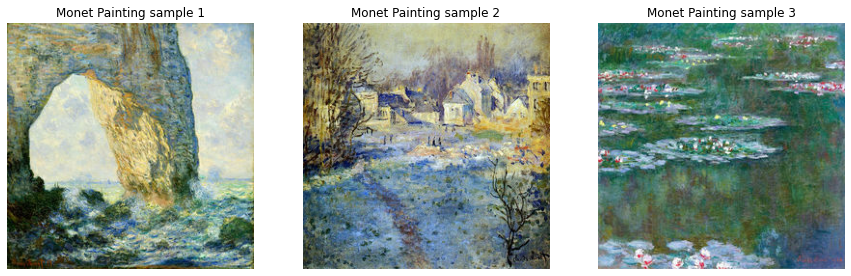

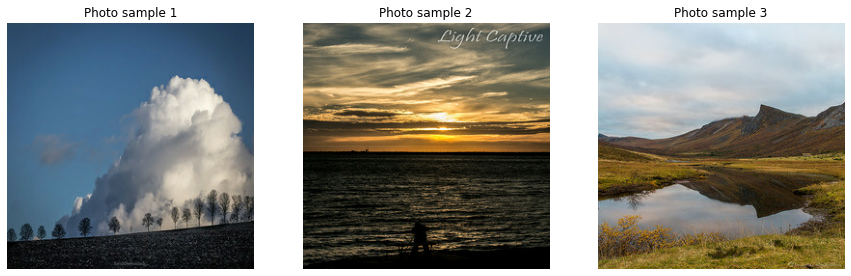

In [12]:
visualize_samples(dataset=monet_ds, title='Monet Painting', n=3)
visualize_samples(dataset=photo_ds, title='Photo', n=3)

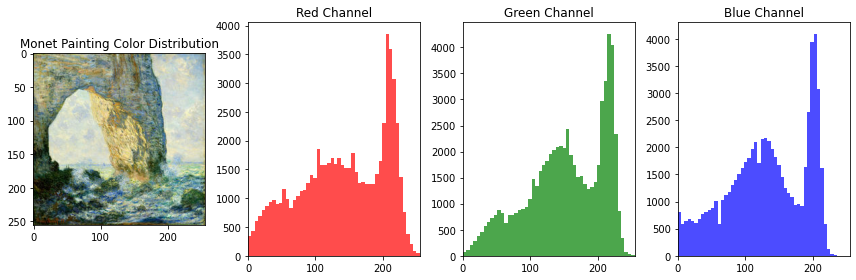

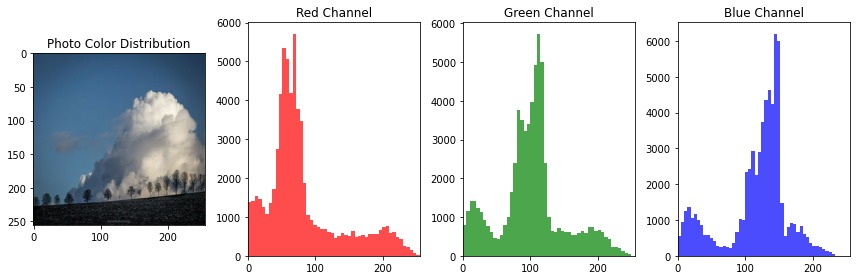

In [13]:
visualize_RGB_distribution(example_monet, 'Monet Painting Color Distribution')
visualize_RGB_distribution(example_photo, 'Photo Color Distribution')

From histogram we see the red in Monet style heavily concentrated in mid range 100+, peak around 200 indicate the warm earth tones, browns, and vibrant reds/pinks in the light-colored rocks, cliffs, and sunlit areas. Sparse happens in low range < 50.
The green chart in Monet style also indicates rich complexity representing the dark, cool foliage/sea and the bright, warm greens used for reflections.
Similar observe in blue chart reflects deep ocean blues (low values) and the white/light-blue pigments used in the sky and highlights, creating a vibrant, luminous feel.
From this, we understand that Generator must learn to shift the distribution of color in photograth into these range of each dimension R, G, B to achieve the characteristic Monet painting style.

# III) Model Architecture

To build our generator, let's first define approach of downsample and upsample methods - we use downsampling path learns the content structure of the input photo, and the upsampling path generates the target Monet style onto that structure
Generally, using downsample to extract feature and semantic understanding, reduce spatial resolution in the image (as pooling method) as filter out the noise.

In [14]:

OUTPUT_CHANNELS = 3 #setup 3 sets for RBG


def downsample(filters, size, apply_instancenorm=True):
    """Downsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        # result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)) #use Instance
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result


then, using upsample to reconstructing the output, adding details and reform to standard image as revert step of Conv2D layer

In [15]:
#SETUP UPSAMPLE FUNCTION

def upsample(filters, size, apply_dropout=False):
    """Upsampling block for the generator"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    # result.add(layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

## 1. Setup model architecture to Generator and Discriminator

### 1.1. Build Generator

### 1.2 Build the discriminator

The discriminator takes in the input image and classifies it as real or fake (generated). Instead of outputing a single node, the discriminator outputs a smaller 2D image with higher pixel values indicating a real classification and lower values indicating a fake classification.
in this approach, we will use PatchGAN to focus building the authentic characters of the ouput on texture, color distribution, and local style to trick Generators.

In [16]:
# define Generator function, using downsample and upsample module prepare earlier to apply on each layer
def Generator():
    """U-Net based generator with skip connections"""
    inputs = layers.Input(shape=[256, 256, 3])

    # Downsampling path
    down_stack = [
        downsample(64, 4, apply_instancenorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Upsampling path
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),  # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                 strides=2,
                                 padding='same',
                                 kernel_initializer=initializer,
                                 activation='tanh')  # (bs, 256, 256, 3) we use tanh to force the generated pixel values into the same defined range as the training data, helping the model quickly cover the color space

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

In [17]:
# setup function for discrinimator,  using downsample and upsample module prepare earlier to apply on each layer
def Discriminator():
    """PatchGAN discriminator that classifies patches of an image as real or fake"""
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    # Downsampling layers
    down1 = downsample(64, 4, apply_instancenorm=False)(x)  # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    # Additional layers
    zero_pad1 = layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, 
                        kernel_initializer=initializer,
                        use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    # norm1 = layers.GroupNormalization(groups=-1, gamma_initializer=gamma_init)(conv) #use Instance
    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)
    leaky_relu = layers.LeakyReLU()(norm1)
    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

    # Output layer - no activation to use with BCE loss
    last = layers.Conv2D(1, 4, strides=1,
                        kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [18]:
with strategy.scope():
    monet_generator = Generator() # transforms any photo input to  Monet painting style
    photo_generator = Generator() # transforms Monet paintings to be more like taken photo
    monet_discriminator = Discriminator() # distinguish actual Monet paintings vs. fake Monet paintings from Generator
    photo_discriminator = Discriminator() # distinguish actual photo taken vs. fake photo by Generator

In [19]:
# LOOK ON MODEL ARCHITECTURE ON MONET SET
print('monet_generator architecture')
monet_generator.summary()

print('monet_discriminator architecture')
monet_discriminator.summary()

monet_generator architecture
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 64, 64, 128)  131328      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 32, 32, 256)  524800      sequential_1[0][0]               
_________________________________________________________________

In [20]:
# LOOK ON MODEL ARCHITECTURE ON PHOTO SET
print('Photo_generator architecture')
photo_generator.summary()

print('Photo_discriminator architecture')
photo_discriminator.summary()

Photo_generator architecture
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
sequential_15 (Sequential)      (None, 128, 128, 64) 3072        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 64, 64, 128)  131328      sequential_15[0][0]              
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 32, 32, 256)  524800      sequential_16[0][0]              
_______________________________________________________________

Now we move to fit in dataset to train the model in CycleGAN setup

## 2. Stacking generator and discriminator to override train_step with CycleGAN


####  Define loss functions

We will define 4 loss functions for a CycleGAN using TensorFlow's distributed training strategy. Resulting set to loss components in single scalar value via tf.reduce_mean().
The functions enforce the adversarial objective (Discriminator/Generator Loss), structural preservation (Cycle Loss), and color consistency (Identity Loss). All losses use Binary Cross-Entropy for the adversarial component and L1 Loss for consistency, with weighting factors applied before the final scalar reduction.

In [21]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        total_disc_loss = real_loss + generated_loss
        return tf.reduce_mean(total_disc_loss) * 0.5

# The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. 
# Thus, it compares the generated image to a matrix of 1s to find the loss.
with strategy.scope():
    def generator_loss(generated):
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
        return tf.reduce_mean(loss) #update

# We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
        loss2 = LAMBDA * loss1 #update
        return tf.reduce_mean(loss2) #udpate

# The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss0 = tf.reduce_mean(tf.abs(real_image - same_image))
        loss = LAMBDA * 0.5 * loss0 #udpate
        return tf.reduce_mean(loss) #update

In [22]:
# building up CycleGAN class:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10, #later session we will tuning this parameter to enhance/reduce effect of detail in image
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn #later to update 
        self.disc_loss_fn = disc_loss_fn #to tune
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## 3. Start training the CycleGAN 

Let's instantiate the adversarial engine with initial learning rate with Adam optimizer and the loss functions were defined above

In [23]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_generator, photo_generator, monet_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [24]:
# training baseline model
baseline_history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20 
)


Epoch 1/20
30/30 [==============================] - 66s 754ms/step - monet_gen_loss: 10.4445 - photo_gen_loss: 10.8291 - monet_disc_loss: 0.6589 - photo_disc_loss: 0.6613
Epoch 2/20
30/30 [==============================] - 23s 753ms/step - monet_gen_loss: 5.4597 - photo_gen_loss: 5.5624 - monet_disc_loss: 0.5827 - photo_disc_loss: 0.6034
Epoch 3/20
30/30 [==============================] - 23s 753ms/step - monet_gen_loss: 5.1753 - photo_gen_loss: 5.3058 - monet_disc_loss: 0.5175 - photo_disc_loss: 0.4984
Epoch 4/20
30/30 [==============================] - 23s 752ms/step - monet_gen_loss: 4.8204 - photo_gen_loss: 5.0253 - monet_disc_loss: 0.6134 - photo_disc_loss: 0.5068
Epoch 5/20
30/30 [==============================] - 24s 751ms/step - monet_gen_loss: 4.5157 - photo_gen_loss: 4.6269 - monet_disc_loss: 0.5422 - photo_disc_loss: 0.5229
Epoch 6/20
30/30 [==============================] - 23s 752ms/step - monet_gen_loss: 4.1612 - photo_gen_loss: 4.3899 - monet_disc_loss: 0.6553 - photo_di

# IV) Results and Analysis

## 1. Result from base model

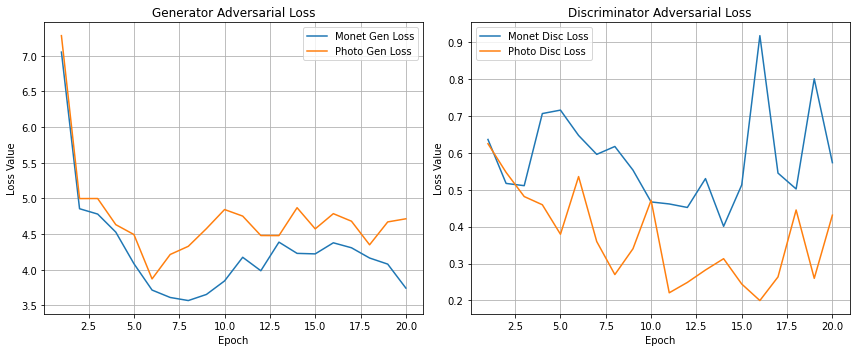

In [25]:
# baseline_history
import matplotlib.pyplot as plt

# Access the loss data 
logs = baseline_history.history
epochs = range(1, len(logs['monet_gen_loss']) + 1)

# Plot Generator Losses 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, logs['monet_gen_loss'], label='Monet Gen Loss')
plt.plot(epochs, logs['photo_gen_loss'], label='Photo Gen Loss')
plt.title('Generator Adversarial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)


# Plot Discriminator Losses 
plt.subplot(1, 2, 2)
plt.plot(epochs, logs['monet_disc_loss'], label='Monet Disc Loss')
plt.plot(epochs, logs['photo_disc_loss'], label='Photo Disc Loss')
plt.title('Discriminator Adversarial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

The Generator shows rapid initial convergence, driven by the strong Cycle Consistency Loss (total loss drops from 7.0 to ≈4.0 by Epoch 5). The Discriminators reach their peak strength (lowest loss) around Epoch 10-15, indicating the Generators were weakest and the Discriminators were best at spotting fakes. However, the subsequent rise in Discriminator loss (after Epoch 15) confirms the Generators are fighting back and getting more reliable in the later epochs. The high volatility and extreme spikes (Monet Disc Loss near 0.9) suggest the Learning Rate is too high, leading to training instability and gradient explosions. The model requires further hyperparameter tuning for a smoother, more controllable convergence

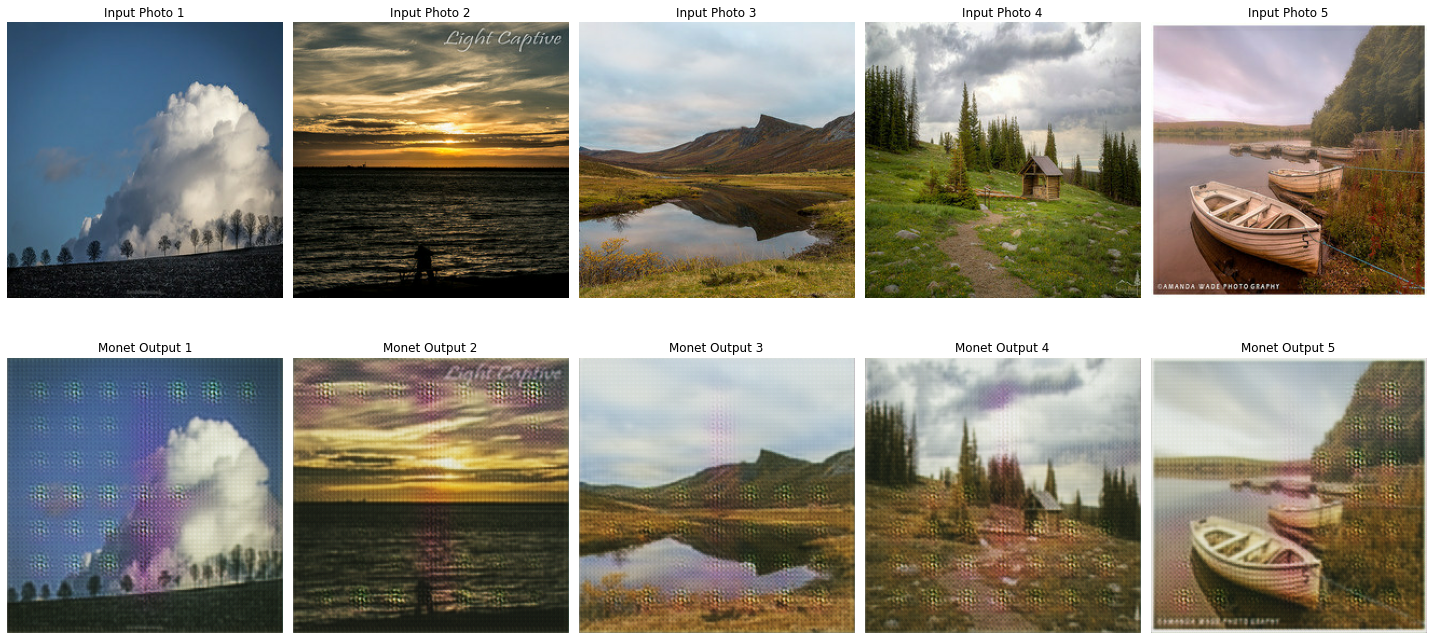

In [26]:
#see the result from baseline model
sample_size = 5

_, ax = plt.subplots(2, sample_size, figsize=(20, 10)) 
for i, img_batch in enumerate(photo_ds.take(sample_size)):
    img = img_batch[0]
    prediction = monet_generator(img_batch, training=False)[0].numpy()
    prediction_display = (prediction * 127.5 + 127.5).astype(np.uint8)
    img_display = (img * 127.5 + 127.5).numpy().astype(np.uint8)

    # 1. Input Photo (First Row: ax[0, i])
    ax[0, i].imshow(img_display)
    ax[0, i].set_title(f"Input Photo {i+1}", fontsize=12)
    ax[0, i].axis("off")

    # 2. Generated Monet (Second Row: ax[1, i])
    ax[1, i].imshow(prediction_display)
    ax[1, i].set_title(f"Monet Output {i+1}", fontsize=12)
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()

## 2. Tuning parameters from base model

### 2.1 Setup: Loss Functions and Optimizers

In [27]:
#we will need to setup the tuning set
def create_tuning_dataset(monet_ds, photo_ds, num_samples, batch_size=1):
    # Ensure both datasets are unbatched individual samples
    if hasattr(monet_ds, '_batch_size') and monet_ds._batch_size is not None:
        monet_ds = monet_ds.unbatch()
    if hasattr(photo_ds, '_batch_size') and photo_ds._batch_size is not None:
        photo_ds = photo_ds.unbatch()
    
    # Take samples from each dataset
    monet_subset = monet_ds.take(num_samples)
    photo_subset = photo_ds.take(num_samples)
    
    # Create a dataset of pairs (this is the key)
    tuning_dataset = tf.data.Dataset.zip((monet_subset, photo_subset))
    tuning_dataset = tuning_dataset.batch(batch_size)
    
    return tuning_dataset

# Utility function to configure optimizers
def configure_optimizers(learning_rate, beta1):
    """Create optimizers with learning rate schedule."""
    lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
        learning_rate,
        decay_steps=500,
        decay_rate=0.8,
        staircase=True
    )
    return [
        tf.keras.optimizers.Adam(lr_scheduler, beta_1=beta1),  # monet_generator_optimizer
        tf.keras.optimizers.Adam(lr_scheduler, beta_1=beta1),  # photo_generator_optimizer
        tf.keras.optimizers.Adam(lr_scheduler, beta_1=beta1),  # monet_discriminator_optimizer
        tf.keras.optimizers.Adam(lr_scheduler, beta_1=beta1)   # photo_discriminator_optimizer
    ]

def build_tunable_cyclegan(hp):
    """Build CycleGAN with tunable hyperparameters using existing models."""
    lr = hp.Choice('learning_rate', values=[1e-4, 3e-4])
    beta1 = hp.Choice('beta1', values=[0.5, 0.7])
    lambda_cycle = hp.Choice('lambda_cycle', values=[5, 10])
    
    with strategy.scope():

        initial_weights = [
            monet_generator.get_weights(),
            photo_generator.get_weights(),
            monet_discriminator.get_weights(),
            photo_discriminator.get_weights()
        ]
        optimizers = configure_optimizers(lr, beta1)
        model = CycleGan(
            monet_generator,
            photo_generator,
            monet_discriminator,
            photo_discriminator,
            lambda_cycle=lambda_cycle
        )
        model.compile(
            m_gen_optimizer=optimizers[0],
            p_gen_optimizer=optimizers[1],
            m_disc_optimizer=optimizers[2],
            p_disc_optimizer=optimizers[3],
            gen_loss_fn=generator_loss,
            disc_loss_fn=discriminator_loss,
            cycle_loss_fn=calc_cycle_loss,
            identity_loss_fn=identity_loss
        )

        # Restore initial weights to ensure consistent starting point
        monet_generator.set_weights(initial_weights[0])
        photo_generator.set_weights(initial_weights[1])
        monet_discriminator.set_weights(initial_weights[2])
        photo_discriminator.set_weights(initial_weights[3])
    
    return model

In [28]:
#checking existing module for Searching best param in current library
import keras_tuner
import inspect

try:
    tuners_module = keras_tuner.tuners
    all_names = dir(tuners_module)
    
    search_classes = []
    for name in all_names:
        obj = getattr(tuners_module, name) # Get the actual object from the module
        if inspect.isclass(obj) and name not in ['__builtins__', '__doc__', '__file__', '__name__', '__package__', '__path__']: # Check if the object is a class and not a built-in function/module/constant
            search_classes.append(name)

    print("List of searchig classes in keras_tuner.tuners")
    if search_classes:
        print(", ".join(sorted(search_classes)))
    else:
        print("No specific search classes found directly in keras_tuner.tuners.")
        
except ImportError as e:
    print(f"Error accessing submodule: {e}")

List of searchig classes in keras_tuner.tuners
BayesianOptimization, Hyperband, RandomSearch, Sklearn, SklearnTuner


In [29]:
TMP_DIR = '../tmp'
IMAGES_TMP_DIR = f'{TMP_DIR}/images'

fine_tuning = True
if fine_tuning:

    if os.path.exists('./hyperparameter_tuning'):
        shutil.rmtree('./hyperparameter_tuning')

    tf.keras.backend.clear_session()
    gc.collect()
    
    TUNING_BATCH_SIZE = 1
    TUNING_SAMPLES = 150 #search params across 150 sample (50%)
    tuning_dataset = create_tuning_dataset(monet_ds, photo_ds, num_samples=TUNING_SAMPLES)
    tuning_dataset


tuner = kt.RandomSearch( #using RandomSearch target to efficiency of this project
    build_tunable_cyclegan,
    objective=kt.Objective('monet_gen_loss', direction="min"),
    max_trials=10, 
    directory=f'{TMP_DIR}/hyperparameter_tuning',
    project_name='cyclegan_grid_tuning'
)

In [30]:
fine_tuning = True
if fine_tuning:
    
    tuner.search(
        tuning_dataset,
        epochs=5, #search in 5 iterations
        callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)],
        verbose=1
    )
    
    best_hps = tuner.get_best_hyperparameters(1)[0]
    learning_rate = best_hps.get('learning_rate')
    beta1 = best_hps.get('beta1')
    lambda_cycle = best_hps.get('lambda_cycle')
    print(f"Best hyperparameters: Learning rate={learning_rate}, Beta1={beta1}, Lambda cycle={lambda_cycle}")

    # Get best hyperparameters
    best_hps = tuner.get_best_hyperparameters(1)[0]
    print(f"Best hyperparameters found:")
    print(f"Learning rate: {best_hps.get('learning_rate')}")
    print(f"Beta1: {best_hps.get('beta1')}")
    print(f"Lambda cycle: {best_hps.get('lambda_cycle')}")

else:
    learning_rate, beta1, lambda_cycle = 3e-4, 0.7, 10 #setup default close to baseline if not using tuning

    # Use last run's best as default
    print(f"Defaulting to Last Run's Best:")
    print(f"Learning rate: {learning_rate}")
    print(f"Beta1: {beta1}")
    print(f"Lambda cycle: {lambda_cycle}")
    

Trial 8 Complete [00h 03m 29s]
monet_gen_loss: 2.0262913703918457

Best monet_gen_loss So Far: 1.9546432495117188
Total elapsed time: 00h 28m 53s
Best hyperparameters: Learning rate=0.0003, Beta1=0.5, Lambda cycle=5
Best hyperparameters found:
Learning rate: 0.0003
Beta1: 0.5
Lambda cycle: 5


result seem to suggest a training strategy that is fast and aggressive, using a higher learning rate & beta, relying less on cycle (lambda reduce from 10 to 5) to achieve a more distinct and powerful style translation.
let's see result on later if this is correct stragety

### 2.2. Updated CycleGan Class using hyper params above

In [31]:
# building up CycleGAN class:
class CycleGan_tune(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=lambda_cycle, 
    ):
        super(CycleGan_tune, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan_tune, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn 
        self.disc_loss_fn = disc_loss_fn 
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

# Compile final CycleGAN model with best hyperparameters
with strategy.scope():
    optimizers = configure_optimizers(learning_rate, beta1)
    cycle_gan_model_tune = CycleGan_tune(
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=lambda_cycle
    )
    cycle_gan_model_tune.compile(
        m_gen_optimizer=optimizers[0],
        p_gen_optimizer=optimizers[1],
        m_disc_optimizer=optimizers[2],
        p_disc_optimizer=optimizers[3],
        gen_loss_fn=generator_loss,
        disc_loss_fn=discriminator_loss,
        cycle_loss_fn=calc_cycle_loss,
        identity_loss_fn=identity_loss
    )

# Consolidated visualization functions for training progress
def generate_images(model, test_input):
    """Generate and display Monet-style images from test input"""
    prediction = model(test_input, training=False)
    
    plt.figure(figsize=(10, 5))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Photo', 'Monet-style Generated']
    
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    
    plt.show()

class DisplayMonitor(keras.callbacks.Callback):
    """Custom callback to display generated images during training"""
    def __init__(self, test_input, interval=5):
        self.test_input = test_input
        self.interval = interval
        
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            clear_output(wait=True)
            print(f"\nEpoch {epoch + 1} Results:")
            generate_images(self.model.m_gen, self.test_input)

In [32]:
# training tuning model
tuning_history = cycle_gan_model_tune.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=20
)


Epoch 1/20
30/30 [==============================] - 58s 750ms/step - monet_gen_loss: 1.8593 - photo_gen_loss: 1.9340 - monet_disc_loss: 0.6647 - photo_disc_loss: 0.6330
Epoch 2/20
30/30 [==============================] - 23s 750ms/step - monet_gen_loss: 1.8530 - photo_gen_loss: 1.9226 - monet_disc_loss: 0.6553 - photo_disc_loss: 0.6350
Epoch 3/20
30/30 [==============================] - 24s 749ms/step - monet_gen_loss: 1.8346 - photo_gen_loss: 1.9113 - monet_disc_loss: 0.6544 - photo_disc_loss: 0.6416
Epoch 4/20
30/30 [==============================] - 23s 749ms/step - monet_gen_loss: 1.8284 - photo_gen_loss: 1.9038 - monet_disc_loss: 0.6648 - photo_disc_loss: 0.6385
Epoch 5/20
30/30 [==============================] - 23s 749ms/step - monet_gen_loss: 1.7988 - photo_gen_loss: 1.8823 - monet_disc_loss: 0.6593 - photo_disc_loss: 0.6447
Epoch 6/20
30/30 [==============================] - 23s 750ms/step - monet_gen_loss: 1.7888 - photo_gen_loss: 1.8726 - monet_disc_loss: 0.6614 - photo_disc

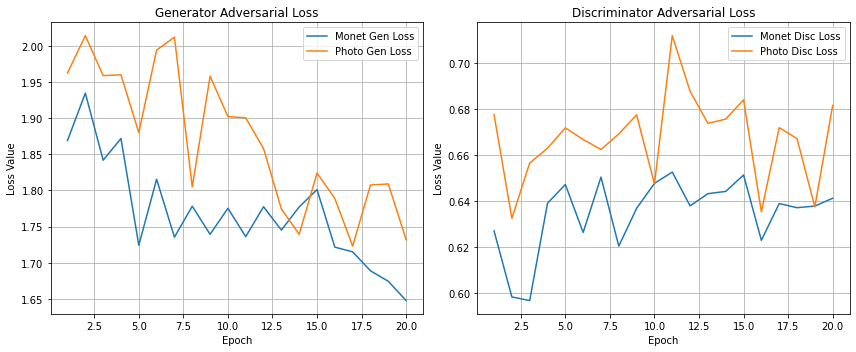

In [33]:
# tuning history
import matplotlib.pyplot as plt

# Access the loss data 
logs = tuning_history.history
epochs = range(1, len(logs['monet_gen_loss']) + 1)

# Plot Generator Losses 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, logs['monet_gen_loss'], label='Monet Gen Loss')
plt.plot(epochs, logs['photo_gen_loss'], label='Photo Gen Loss')
plt.title('Generator Adversarial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)


# Plot Discriminator Losses 
plt.subplot(1, 2, 2)
plt.plot(epochs, logs['monet_disc_loss'], label='Monet Disc Loss')
plt.plot(epochs, logs['photo_disc_loss'], label='Photo Disc Loss')
plt.title('Discriminator Adversarial Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

while the Monet Generator is stabilizing and succeeding, the overall system is still suffering from high volatility and a weak Photo Discriminator. We will analyze next work need to be done in later session

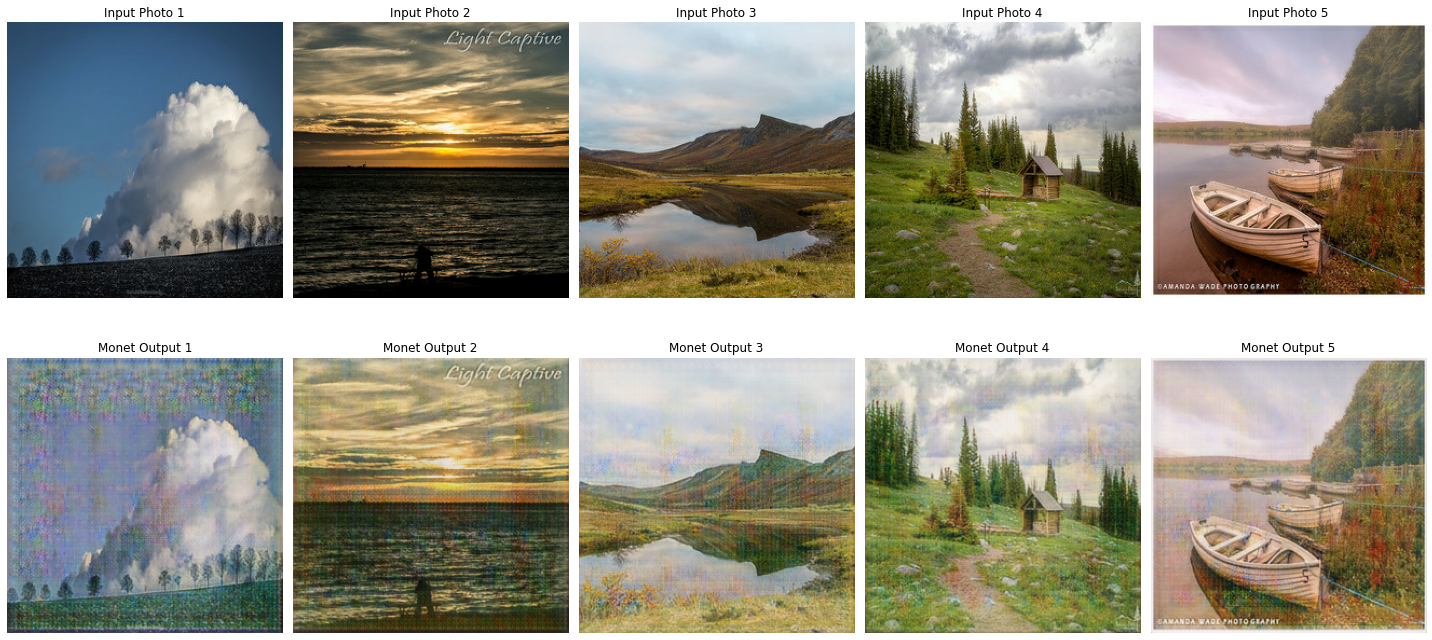

In [34]:
#visualize the image generated by tune_model
tuned_monet_generator = cycle_gan_model_tune.m_gen 
sample_size = 5

_, ax = plt.subplots(2, sample_size, figsize=(20, 10)) 

for i, img_batch in enumerate(photo_ds.take(sample_size)):
    # 1. Extract the single image tensor 
    img = img_batch[0]
    
    # 2. Add the batch dimension back for the generator model
    img_for_generator = tf.expand_dims(img, axis=0) 
    
    prediction = tuned_monet_generator(img_for_generator, training=False)[0].numpy() 
    
    # Rescaling and Display 
    prediction_display = (prediction * 127.5 + 127.5).astype(np.uint8) 
    img_display = (img * 127.5 + 127.5).numpy().astype(np.uint8)

    # 1. Input Photo
    ax[0, i].imshow(img_display)
    ax[0, i].set_title(f"Input Photo {i+1}", fontsize=12)
    ax[0, i].axis("off")

    # 2. Generated Monet
    ax[1, i].imshow(prediction_display)
    ax[1, i].set_title(f"Monet Output {i+1}", fontsize=12)
    ax[1, i].axis("off")

plt.tight_layout()
plt.show()

## 3. Create submission file

as we see performnace of baseline model is more stable than tuning model, we will use this baseline to predict test photo for submission

In [35]:
#GENERATE MONET STYLE FROM 7K INPUT FOLLOW MONET STYLE
import PIL
! mkdir ../images

i = 1
for img in photo_ds:
    prediction = monet_generator(img, training=False)[0].numpy() #to update monet_generator2
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8) #to update prediction2
    im = PIL.Image.fromarray(prediction) #prediction2
    im.save("../images/" + str(i) + ".jpg")
    i += 1

# THIS IS SAVING FOR LATER EXPERIMENT WHEN TUNIGN MODEL PERFORM BETTER, THEN RESULT WILL BE SUBMIT FROM THIS GENERATOR
# import PIL.Image

# i = 1
# # Extract generator that was trained and tuned 
# tuned_monet_generator = cyclegan_model_tune.m_gen 

# for img in photo_ds:
#     prediction = tuned_monet_generator(img, training=False)[0].numpy() 
#     prediction = (prediction * 127.5 + 127.5).astype(np.uint8) 
#     im = PIL.Image.fromarray(prediction)
#     im.save("../images/" + str(i) + ".jpg")
#     i += 1

In [36]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images") #submit again

'/kaggle/working/images.zip'

as first submission on CycleGAN without tuning, reaching score at 61. The later submission encounter error thus I kept this score 0.61 as reference for the practice

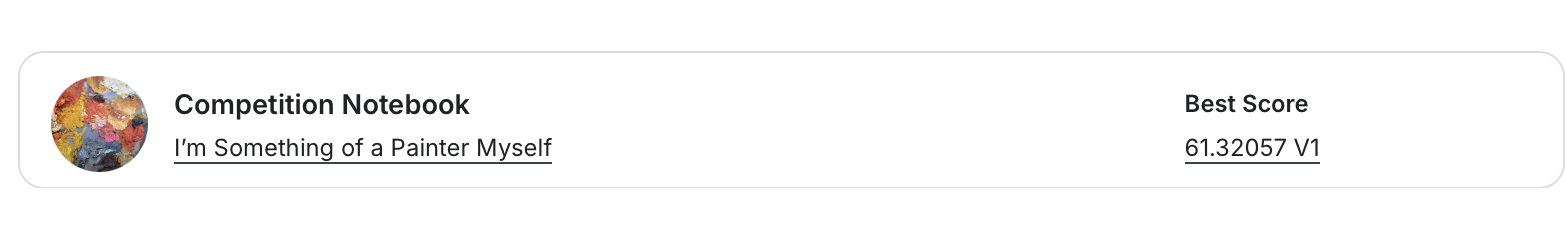

In [1]:
from IPython.display import Image, display
display(Image(filename='Kaggle score.png'))

# V) Conclusion 

**Key takeaways**
1) Trade-off of hyper params effect, the best params from hyper-tuning (e.g., Learning Rate, beta...) effectively optimized training stability and control by using a conservative learning rate and beta near 0.5. However, this improved stability cost to training efficiency (slower epoch completion) without guaranteeing immediate improvement in the final output quality.

2) Convergence character in baseline model show faster initial convergence driven by fast weight updates, but also lead to unstable performance. In the opposite, tuning model show slower, smoother convergence with more controled loss fluctuations, suggest more reliable for achieving optimal visual results.

3) by eyes sensing, I personally prefer converted image from tuning model, however it's still a lot more to explore and finetuning it. Let me know your favorite in comment session.

**Future work**

As the current hyperparameter search resulted in a less efficient training pipeline (slower time per epoch) compared to the baseline, future work will focus on more intelligent optimization:

1) improving hyperparameter search: I will update simple randomized search to Bayesian Optimization to efficiently explore the hyperparameter space. This will prioritize finding configurations that optimize for both speed and stability.

2) loss function: I will continue exploring different loss functions, potentially implementing the Wasserstein GAN with Gradient Penalty (WGAN-GP) loss to further stabilize the adversarial dynamics and assess its impact on final image fidelity against the current configuration.

3) Generator regularization: I will integrate a Fake Image history buffer to the Discriminators, smoothing the training signal and mitigating the volatility observed in the loss plots, thereby improving the long-term reliability of the model.

# VI) Produce Deliverables: High-Quality, Organized Jupyter Notebook Report, GitHub Repository, and screenshot of Kaggle leaderboard

### This work inspired by these references:
1. tuning hyper param: https://www.kaggle.com/code/carlosmatherson/monet-cyclegan
2. loading dataset and initial guidance from: https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial
3. initial ideas on Generator & Discriminator: https://keras.io/examples/generative/dcgan_overriding_train_step/

### Github link: 
https://github.com/GabyVothy/DeepLearning/blob/main/cyclegan-on-monet.ipynb